In [1]:
#!pip install -r requirements.txt

import os
os.environ['PATH'] += os.pathsep + '/home/jovyan/.local/bin'

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import itertools
import random
import json
import sys

# Load data

In [3]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [4]:
flist = s3.glob('s3://jec-data/open-small/100*.root')

In [5]:
from utils.config import DataConfig
from utils.fileio import read_files
from utils.preprocess import build_new_variables, finalize_inputs

def get_data(data_config_file):
    data_config = DataConfig.load(data_config_file)
    table = read_files(flist, data_config.load_branches, s3)
    # define new variables
    build_new_variables(table, data_config.var_funcs)
    # perform input variable standardization, clipping, padding and stacking
    finalize_inputs(table, data_config)
    
    input_data = {key: table[f'_{key}'] for key in data_config.inputs.keys()}
    
    observers = ak.to_dataframe({k: table[k] for k in data_config.observers})
    
    return input_data, observers

In [6]:
pfn_input_data, observers = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_pfn_open.yaml')
for key in pfn_input_data:
    print(key, pfn_input_data[key].shape)

/home/jovyan/.local/lib/python3.8/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


pf_features (8990, 6, 100)
pf_mask (8990, 1, 100)
jet_features (8990, 8)


In [7]:
particlenet_input_data, _ = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_particle_net_open.yaml')
for key in particlenet_input_data:
    print(key, particlenet_input_data[key].shape)

/home/jovyan/.local/lib/python3.8/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


pf_points (8990, 2, 100)
pf_features (8990, 6, 100)
pf_mask (8990, 1, 100)
jet_features (8990, 8)


In [8]:
observers.head()

,jetPt,genJetPt,genJetEta,partonFlav,hadronFlav
entry,,,,,
0,71.932236,73.155434,-1.344992,3.0,0.0
1,67.177696,73.371246,-0.401511,21.0,0.0
2,107.918228,103.446953,1.872291,21.0,0.0
3,88.393539,78.820610,1.535389,1.0,0.0
4,30.975452,29.149637,0.525930,21.0,0.0


In [9]:
df = observers.copy()
df.columns = ['pt', 'pt_gen', 'eta_gen', 'parton_flavor', 'hadron_flavor']
df['flavour'] = df.hadron_flavor.where(df.hadron_flavor != 0, other=np.abs(df.parton_flavor))
df = df.drop(columns=['parton_flavor', 'hadron_flavor'])
df.head()

,pt,pt_gen,eta_gen,flavour
entry,,,,
0,71.932236,73.155434,-1.344992,3.0
1,67.177696,73.371246,-0.401511,21.0
2,107.918228,103.446953,1.872291,21.0
3,88.393539,78.820610,1.535389,1.0
4,30.975452,29.149637,0.525930,21.0


In [10]:
data_len = df.shape[0]

In [11]:
outdir = 'figs/data'

for ext in ['png', 'pdf']:
    os.makedirs(os.path.join(outdir, ext), exist_ok=True)

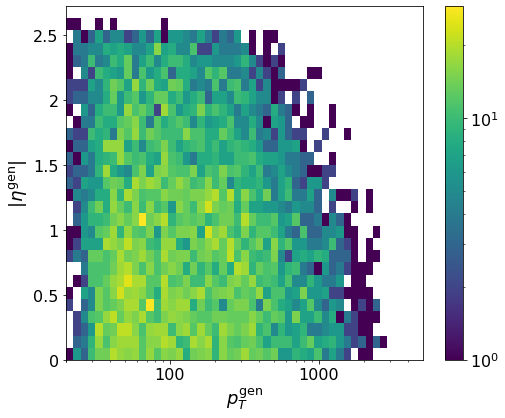

<Figure size 432x288 with 0 Axes>

In [12]:
from utils.visualize_data import plot_spectrum

plot_spectrum(df, outdir)

In [13]:
filtered = df[(df.pt_gen > 20) & (np.abs(df.eta_gen) < 2.5)]

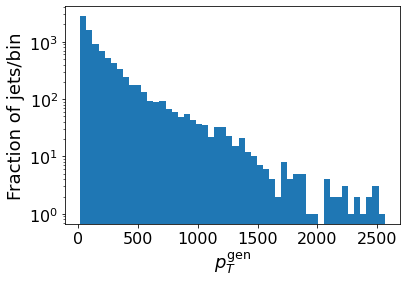

In [14]:
plt.hist(filtered.pt_gen, bins=50)
plt.xlabel('$p_T^\mathrm{gen}$')
plt.ylabel('Fraction of jets/bin')
plt.yscale('log')
plt.show()

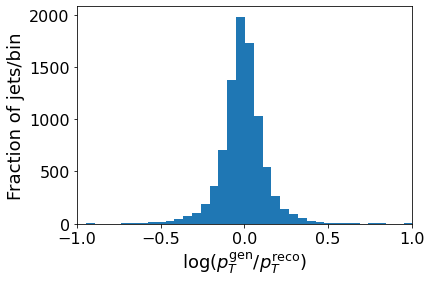

<Figure size 432x288 with 0 Axes>

In [15]:
from utils.visualize_data import plot_target

plot_target(filtered, outdir)

# Triton inference

### Set up client

In [16]:
import tritonclient.http as httpclient

In [17]:
pfn_triton_client = httpclient.InferenceServerClient(url='pfn-regressor-open-92b681.dholmber.svc.cluster.local', verbose=False)
particlenet_triton_client = httpclient.InferenceServerClient(url='particle-net-regressor-open-b725de.dholmber.svc.cluster.local', verbose=False)

In [18]:
def infer(triton_client, inputs):
    triton_inputs = []
    for i, key in enumerate(inputs.keys()):
        triton_inputs.append(httpclient.InferInput(name=key, shape=inputs[key].shape, datatype="FP32"))
        triton_inputs[i].set_data_from_numpy(inputs[key])

    triton_outputs = [httpclient.InferRequestedOutput(name='output')]

    results = triton_client.infer(
        model_name='optimal',
        inputs=triton_inputs,
        outputs=triton_outputs
    )
    return results

### Initialize inference experiment parameters

In [19]:
num_repeats = 10
batch_sizes = range(10, 110, 10)

### Gather statistics

In [20]:
def gather_statistics(triton_client, input_data, num_repeats, batch_sizes):
    batch_stats = {batch_size: {'inference_time': [], 'inference_count': 0, 'total_inference_time': 0} for batch_size in batch_sizes}
    
    statistics = triton_client.get_inference_statistics(model_name='optimal')
    initial_batch_stats = statistics['model_stats'][0]['batch_stats']

    for initial_stat in initial_batch_stats:
        batch_size = initial_stat['batch_size']
        if batch_size in batch_sizes:
            initial_inference = initial_stat['compute_infer']
            batch_stats[batch_size]['total_inference_time'] = initial_inference['ns']

    for batch_size in tqdm(batch_sizes):
        while batch_stats[batch_size]['inference_count'] < num_repeats:
            indices = random.sample(range(data_len), batch_size)
            inputs = {}
            for key in input_data:
                inputs[key] = input_data[key][indices]

            results = infer(triton_client, inputs)

            statistics = triton_client.get_inference_statistics(model_name='optimal')
            all_current_batch_stats = statistics['model_stats'][0]['batch_stats']
            for stat in all_current_batch_stats:
                if stat['batch_size'] == batch_size:
                    current_batch = stat
                    break

            last_inference_time = current_batch['compute_infer']['ns'] - batch_stats[batch_size]['total_inference_time']

            batch_stats[batch_size]['inference_time'].append(last_inference_time / batch_size)
            batch_stats[batch_size]['total_inference_time'] = current_batch['compute_infer']['ns']
            batch_stats[batch_size]['inference_count'] += 1
    
    return batch_stats

In [21]:
pfn_batch_stats = gather_statistics(pfn_triton_client, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


In [22]:
particle_net_batch_stats = gather_statistics(particlenet_triton_client, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


### Calculate metrics

In [23]:
def calculate_metrics(batch_stats, batch_sizes):
    y = []
    yerr = []
    for batch_size in batch_sizes:
        batch_inference_time = [t / 1000 for t in batch_stats[batch_size]['inference_time']]

        summed_time = sum(batch_inference_time)
        count = batch_stats[batch_size]['inference_count']
        if not count:
            continue

        mean_time = summed_time / count
        y.append(mean_time)

        sem = np.std(batch_inference_time, ddof=1) / np.sqrt(np.size(batch_inference_time))
        yerr.append(sem)
    
    return y, yerr

In [24]:
pfn_y, pfn_yerr = calculate_metrics(pfn_batch_stats, batch_sizes)

In [25]:
particlenet_y, particlenet_yerr = calculate_metrics(particle_net_batch_stats, batch_sizes)

### Plot inference time

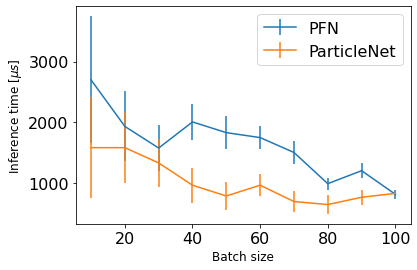

In [26]:
plt.errorbar(x=batch_sizes, y=pfn_y, yerr=pfn_yerr, label='PFN')
plt.errorbar(x=batch_sizes, y=particlenet_y, yerr=particlenet_yerr, label='ParticleNet')
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Inference time [$\mu s$]', fontsize=12)
plt.legend()
plt.savefig('figs/inference_time.png')
plt.show()

# Physics results

In [27]:
batch_size = 100

In [28]:
def get_predictions(triton_client, input_data):
    predictions = []

    for i in tqdm(range(0, data_len, batch_size)):
        inputs = {}
        for key in input_data:
            inputs[key] = input_data[key][i:i+batch_size]

        results = infer(triton_client, inputs)

        predictions.append(results.as_numpy(name='output'))

    return np.concatenate(predictions)

In [29]:
pfn_predictions = get_predictions(pfn_triton_client, pfn_input_data)

100%|██████████| 90/90 [00:09<00:00,  9.11it/s]


In [30]:
particlenet_predictions = get_predictions(particlenet_triton_client, particlenet_input_data)

100%|██████████| 90/90 [00:06<00:00, 14.33it/s]


In [31]:
outdir = 'figs'
network_names = ['PFN-r', 'ParticleNet-r']
names = ['Standard'] + network_names
preds = {'PFN-r': pfn_predictions.squeeze(), 'ParticleNet-r': particlenet_predictions.squeeze()}

In [32]:
df['Standard'] = df.pt / df.pt_gen
for name in network_names:
    corrected_pt = np.exp(preds[name]) * df.pt
    df[name] = corrected_pt / df.pt_gen

binning = np.geomspace(20, 3000, 20)
bin_centers = np.sqrt(binning[:-1] * binning[1:])

In [33]:
os.makedirs(outdir, exist_ok=True)

for subdir in ['distributions', 'flavours', 'response', 'resolution', 'residual']:
    for ext in ['png', 'pdf']:
        os.makedirs(os.path.join(outdir, subdir, ext), exist_ok=True)

In [34]:
# del sys.modules[compare_flavours.__module__]
# del sys.modules[plot_resolution.__module__]
# del sys.modules[plot_median_response.__module__]
# del sys.modules[compute_resolution_improvement.__module__]
# del sys.modules[to_serializable.__module__]
# del sys.modules[plot_distrs.__module__]
# del sys.modules[plot_median_residual.__module__]

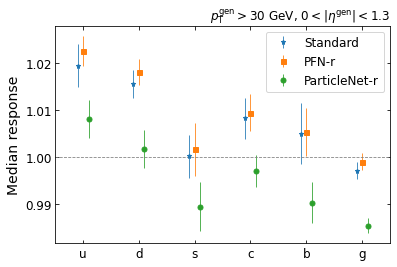

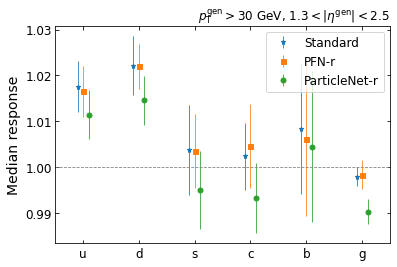

In [35]:
%%capture --no-display
from utils.plot import compare_flavours

compare_flavours(df, names, os.path.join(outdir, 'flavours'))

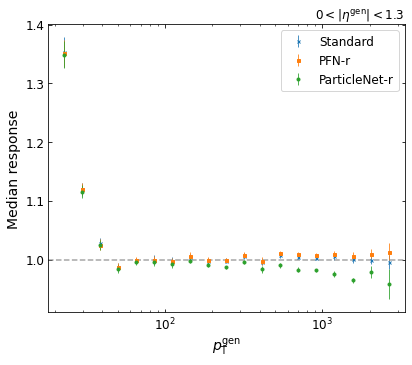

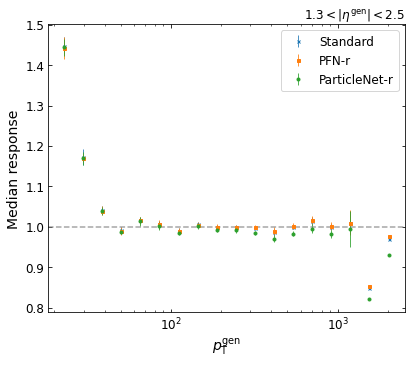

In [36]:
from utils.plot import plot_median_response

for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    plot_median_response(
        os.path.join(outdir, 'response'),
        flavour_label, bins, bin_centers, eta_bin, ieta, names
    )

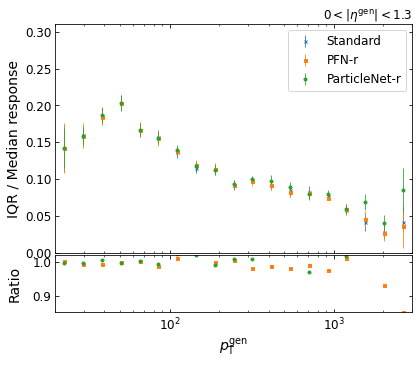

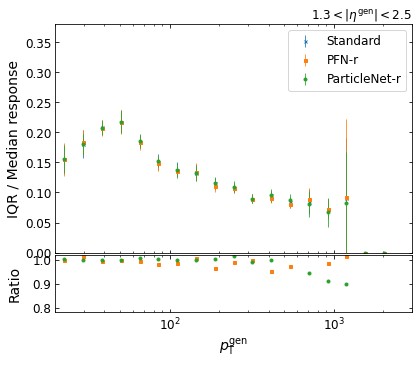

In [37]:
from utils.plot import plot_resolution, compute_resolution_improvement, to_serializable

data = {}
for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    data[f'{flavour_label}_eta{ieta}'] = plot_resolution(
        os.path.join(outdir, 'resolution'),
        flavour_label, bins, bin_centers, eta_bin, ieta, binning, names
    )

    for (ipt, pt_bin) in enumerate(
            [(30, np.inf), (30, 50), (50, 100), (100, 300), (300, 1000), (1000, np.inf)], start=1
        ):
        pt_bin = df_bin[
            (df_bin.pt_gen >= pt_bin[0])
            & (df_bin.pt_gen < pt_bin[1])
        ]
        data[f'{flavour_label}_eta{ieta}']['improvement'][f'pt{ipt}'] = compute_resolution_improvement(pt_bin, names)

with open(os.path.join(outdir, 'resolution', 'data.json'), 'w') as f:
    json.dump(data, f, indent='\t', default=to_serializable)

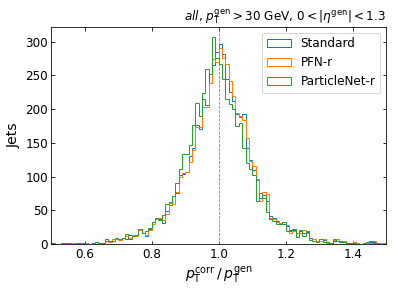

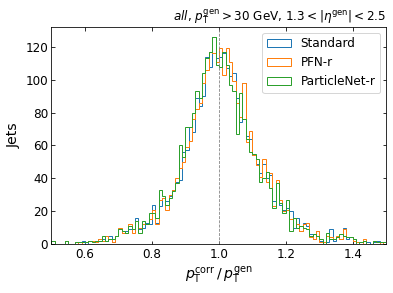

In [38]:
from utils.plot import plot_distrs

plot_distrs(df, names, os.path.join(outdir, 'distributions'))

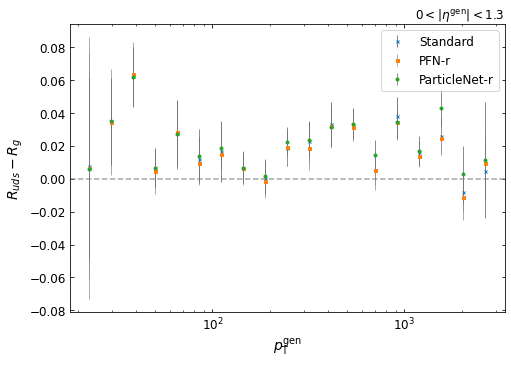

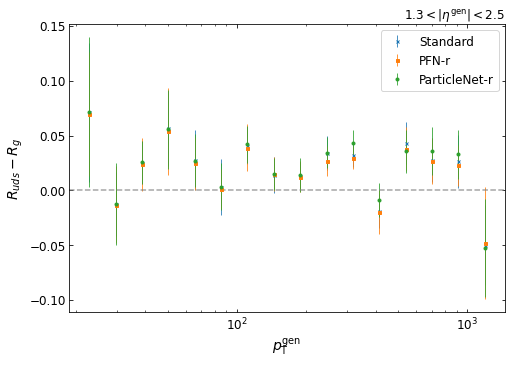

In [39]:
from utils.plot import plot_median_residual

for (ieta, eta_bin), flavours in itertools.product(
    enumerate([(0, 1.3), (1.3, 2.5)], start=1),
    itertools.combinations([('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21})], r=2),
):
    bins = []
    for i, flavour_ids in enumerate([flavours[0][1], flavours[1][1]]):
        df_bin = df[
            (np.abs(df.eta_gen) >= eta_bin[0])
            & (np.abs(df.eta_gen) < eta_bin[1])
            & df.flavour.isin(flavour_ids)
        ]
        bins.append(df_bin.groupby(pd.cut(df_bin.pt_gen, binning)))

    plot_median_residual(
        os.path.join(outdir, 'residual'),
        bin_centers, (flavours[0][0], flavours[1][0]), bins, eta_bin, ieta, names
    )